# 🚀 CORD Dataset Exploration for Auto-Bookkeeper

This notebook explores the CORD v2 dataset to understand:
1. **What data is available** in `gt_parse` (ground truth)
2. **What's missing** that we need to extract from images
3. **How to ingest** the JSON data into our SQLite database

## Key Insight from Hackathon Specs:
> "Load & ingest receipts (**JSON from CORD dataset**)"

This means we primarily use the **pre-extracted JSON**, not raw OCR on images!

In [1]:
# Install required packages
!pip install datasets pandas pillow -q

In [3]:
# Load CORD dataset - VALIDATION split only (100 samples, much smaller!)
from datasets import load_dataset
import json

print("Loading CORD v2 dataset - validation split only...")
dataset = load_dataset("naver-clova-ix/cord-v2", split="validation")

print(f"Loaded {len(dataset)} validation samples")
print(f"Features: {dataset.features}")

Loading CORD v2 dataset - validation split only...


Generating test split: 100%|██████████| 100/100 [00:00<00:00, 246.03 examples/s]

Loaded 100 validation samples
Features: {'image': Image(mode=None, decode=True), 'ground_truth': Value('string')}


## 📊 Explore Dataset Structure

Let's look at what each sample contains:

In [4]:
# Look at first sample
sample = dataset[0]
print("Keys in each sample:", sample.keys())
print("\n" + "="*50)

# The ground_truth is a JSON string - parse it
gt = json.loads(sample['ground_truth'])
print("\nGround truth structure:")
print(json.dumps(gt, indent=2)[:2000] + "...")

Keys in each sample: dict_keys(['image', 'ground_truth'])


Ground truth structure:
{
  "gt_parse": {
    "menu": [
      {
        "nm": "REAL GANACHE",
        "cnt": "1",
        "price": "16,500"
      },
      {
        "nm": "EGG TART",
        "cnt": "1",
        "price": "13,000"
      },
      {
        "nm": "PIZZA TOAST",
        "cnt": "1",
        "price": "16,000"
      }
    ],
    "total": {
      "total_price": "45,500",
      "cashprice": "50,000",
      "changeprice": "4,500"
    }
  },
  "meta": {
    "version": "2.0.0",
    "split": "valid",
    "image_id": 0,
    "image_size": {
      "width": 864,
      "height": 1296
    }
  },
  "valid_line": [
    {
      "words": [
        {
          "quad": {
            "x2": 194,
            "y3": 586,
            "x3": 194,
            "y4": 586,
            "x1": 176,
            "y1": 556,
            "x4": 176,
            "y2": 556
          },
          "is_key": 0,
          "row_id": 2068522,
          "text": "1"

In [5]:
# Extract gt_parse - this is what we need for ingestion!
gt_parse = gt.get('gt_parse', {})
print("📦 gt_parse keys:", gt_parse.keys())
print("\n" + "="*50)

# Check what's in gt_parse
for key in gt_parse.keys():
    print(f"\n🔹 {key}:")
    print(json.dumps(gt_parse[key], indent=2)[:500])

📦 gt_parse keys: dict_keys(['menu', 'total'])


🔹 menu:
[
  {
    "nm": "REAL GANACHE",
    "cnt": "1",
    "price": "16,500"
  },
  {
    "nm": "EGG TART",
    "cnt": "1",
    "price": "13,000"
  },
  {
    "nm": "PIZZA TOAST",
    "cnt": "1",
    "price": "16,000"
  }
]

🔹 total:
{
  "total_price": "45,500",
  "cashprice": "50,000",
  "changeprice": "4,500"
}


## 🔍 Analyze Field Availability Across Dataset

Let's check how often each field appears in gt_parse:

In [6]:
# Analyze field availability across validation samples
from collections import Counter

field_counts = Counter()
sub_field_counts = {
    'menu': Counter(),
    'sub_total': Counter(),
    'total': Counter(),
    'store_info': Counter(),
}

total_samples = len(dataset)

for sample in dataset:
    gt = json.loads(sample['ground_truth'])
    gt_parse = gt.get('gt_parse', {})
    
    for key in gt_parse.keys():
        field_counts[key] += 1
        
        # Count sub-fields
        if key in sub_field_counts:
            if isinstance(gt_parse[key], list):
                # For menu items, check first item
                if len(gt_parse[key]) > 0:
                    for subkey in gt_parse[key][0].keys():
                        sub_field_counts[key][subkey] += 1
            elif isinstance(gt_parse[key], dict):
                for subkey in gt_parse[key].keys():
                    sub_field_counts[key][subkey] += 1

print(f"📊 Field availability across {total_samples} receipts:\n")
print("="*50)
for field, count in field_counts.most_common():
    pct = count / total_samples * 100
    emoji = "✅" if pct > 80 else "⚠️" if pct > 50 else "❌"
    print(f"{emoji} {field}: {count}/{total_samples} ({pct:.1f}%)")

📊 Field availability across 100 receipts:

✅ menu: 100/100 (100.0%)
✅ total: 100/100 (100.0%)
⚠️ sub_total: 67/100 (67.0%)


In [7]:
# Show sub-field availability
print("\n" + "="*50)
print(f"\n📋 Sub-field availability (out of {total_samples} samples):\n")

for parent, counts in sub_field_counts.items():
    if counts:
        print(f"\n🔹 {parent}:")
        for field, count in counts.most_common():
            pct = count / total_samples * 100
            print(f"   - {field}: {count} ({pct:.1f}%)")



📋 Sub-field availability (out of 100 samples):


🔹 menu:
   - nm: 100 (100.0%)
   - price: 99 (99.0%)
   - cnt: 94 (94.0%)
   - unitprice: 30 (30.0%)
   - sub: 18 (18.0%)
   - discountprice: 3 (3.0%)
   - num: 2 (2.0%)
   - vatyn: 1 (1.0%)

🔹 sub_total:
   - subtotal_price: 67 (67.0%)
   - tax_price: 47 (47.0%)
   - service_price: 13 (13.0%)
   - discount_price: 6 (6.0%)
   - etc: 1 (1.0%)

🔹 total:
   - total_price: 98 (98.0%)
   - cashprice: 64 (64.0%)
   - changeprice: 64 (64.0%)
   - menuqty_cnt: 26 (26.0%)
   - creditcardprice: 14 (14.0%)
   - emoneyprice: 4 (4.0%)
   - total_etc: 4 (4.0%)
   - menutype_cnt: 3 (3.0%)


## 🖼️ View Sample Receipt Image

📝 Extracted data from this receipt:
{
  "menu": {
    "nm": "LE MINERAL",
    "cnt": "1.00",
    "price": "8,000"
  },
  "sub_total": {
    "subtotal_price": "7,273",
    "tax_price": "727"
  },
  "total": {
    "total_price": "8,000",
    "cashprice": "8,000"
  }
}

🖼️ Receipt image:


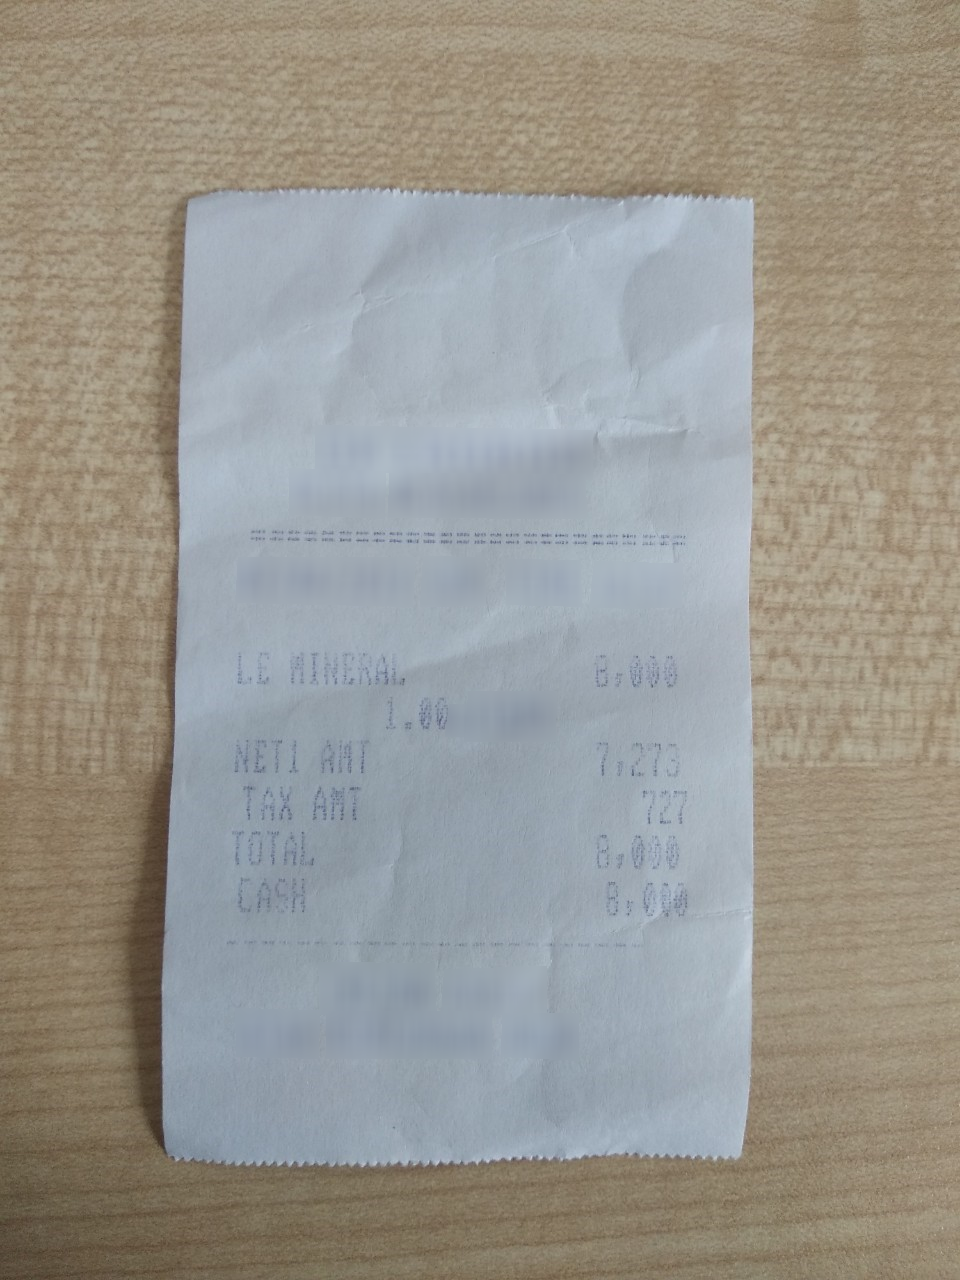

In [8]:
# Display a sample receipt image
from IPython.display import display

sample = dataset[5]
gt = json.loads(sample['ground_truth'])
gt_parse = gt.get('gt_parse', {})

print("📝 Extracted data from this receipt:")
print(json.dumps(gt_parse, indent=2))
print("\n🖼️ Receipt image:")
display(sample['image'])

## 💾 Convert CORD Data to Our Database Schema

Now let's convert the CORD gt_parse format to match our SQLite schema:

In [16]:
def parse_cord_price(price_str):
    """Convert CORD price string to float (e.g., '16,500' -> 16500)"""
    if not price_str:
        return None
    # Remove all non-numeric characters except decimal point
    cleaned = ''.join(c for c in str(price_str) if c.isdigit())
    return int(cleaned) if cleaned else None

def get_item_name(nm):
    """Safely extract item name - handles both string and list cases"""
    if nm is None:
        return "Unknown Item"
    if isinstance(nm, list):
        # Join list items with space
        return ' '.join(str(n) for n in nm if n)
    return str(nm) if nm else "Unknown Item"

def cord_to_receipt(sample_idx, sample):
    """Convert a CORD sample to our receipt format - using only available data with fallbacks"""
    gt = json.loads(sample['ground_truth'])
    gt_parse = gt.get('gt_parse', {})
    
    # Extract vendor info (use fallback if not available)
    store_info = gt_parse.get('store_info', {})
    vendor = {
        'name': store_info.get('name') if isinstance(store_info, dict) and store_info.get('name') else "Unknown Vendor",
        'address': store_info.get('addr') if isinstance(store_info, dict) else None,
        'phone': store_info.get('tel') if isinstance(store_info, dict) else None,
        'business_number': store_info.get('biznum') if isinstance(store_info, dict) else None,
    }
    
    # Extract totals
    total_info = gt_parse.get('total', {})
    sub_total = gt_parse.get('sub_total', {})
    
    # Determine payment method from available data
    payment_method = "unknown"
    if isinstance(total_info, dict):
        if total_info.get('cashprice'):
            payment_method = "cash"
        elif total_info.get('creditcardprice'):
            payment_method = "card"
        elif total_info.get('emoneyprice'):
            payment_method = "e-money"
    
    receipt = {
        'id': f"cord_{sample_idx:04d}",
        'vendor_name': vendor['name'],
        'date': None,  # Not available in CORD gt_parse - use fallback
        'subtotal': parse_cord_price(sub_total.get('subtotal_price')) if isinstance(sub_total, dict) else None,
        'tax_amount': parse_cord_price(sub_total.get('tax_price')) if isinstance(sub_total, dict) else None,
        'service_charge': parse_cord_price(sub_total.get('service_price')) if isinstance(sub_total, dict) else None,
        'discount': parse_cord_price(sub_total.get('discount_price')) if isinstance(sub_total, dict) else None,
        'total_amount': parse_cord_price(total_info.get('total_price')) if isinstance(total_info, dict) else 0,
        'cash_paid': parse_cord_price(total_info.get('cashprice')) if isinstance(total_info, dict) else None,
        'card_paid': parse_cord_price(total_info.get('creditcardprice')) if isinstance(total_info, dict) else None,
        'change_amount': parse_cord_price(total_info.get('changeprice')) if isinstance(total_info, dict) else None,
        'payment_method': payment_method,
        'category': "Uncategorized",  # Default category - can be updated later
    }
    
    # Extract line items
    items = []
    menu = gt_parse.get('menu', [])
    if isinstance(menu, list):
        for item in menu:
            if isinstance(item, dict):
                items.append({
                    'name': get_item_name(item.get('nm')),
                    'quantity': parse_cord_price(item.get('cnt')) or 1,
                    'unit_price': parse_cord_price(item.get('unitprice')),
                    'total_price': parse_cord_price(item.get('price')) or 0,
                })
    elif isinstance(menu, dict):
        # Single item case
        items.append({
            'name': get_item_name(menu.get('nm')),
            'quantity': parse_cord_price(menu.get('cnt')) or 1,
            'unit_price': parse_cord_price(menu.get('unitprice')),
            'total_price': parse_cord_price(menu.get('price')) or 0,
        })
    
    # Calculate items sum for error flagging
    items_sum = sum(item['total_price'] for item in items)
    total = receipt['total_amount'] or 0
    
    # Flag if items don't sum to total (potential error)
    has_error = False
    if total > 0 and items_sum > 0:
        diff_pct = abs(items_sum - total) / total
        has_error = diff_pct > 0.20  # >20% difference is flagged
    
    receipt['has_error'] = has_error
    receipt['items_sum'] = items_sum
    
    return {
        'vendor': vendor,
        'receipt': receipt,
        'items': items,
    }

# Test with first sample
test_result = cord_to_receipt(0, dataset[0])
print("🧪 Converted receipt (with fallbacks):")
print(json.dumps(test_result, indent=2, default=str))

🧪 Converted receipt (with fallbacks):
{
  "vendor": {
    "name": "Unknown Vendor",
    "address": null,
    "phone": null,
    "business_number": null
  },
  "receipt": {
    "id": "cord_0000",
    "vendor_name": "Unknown Vendor",
    "date": null,
    "subtotal": null,
    "tax_amount": null,
    "service_charge": null,
    "discount": null,
    "total_amount": 45500,
    "cash_paid": 50000,
    "card_paid": null,
    "change_amount": 4500,
    "payment_method": "cash",
    "category": "Uncategorized",
    "has_error": false,
    "items_sum": 45500
  },
  "items": [
    {
      "name": "REAL GANACHE",
      "quantity": 1,
      "unit_price": null,
      "total_price": 16500
    },
    {
      "name": "EGG TART",
      "quantity": 1,
      "unit_price": null,
      "total_price": 13000
    },
    {
      "name": "PIZZA TOAST",
      "quantity": 1,
      "unit_price": null,
      "total_price": 16000
    }
  ]
}


## 📤 Batch Convert All Receipts and Check Data Quality

In [17]:
# Convert all validation samples
import pandas as pd

all_receipts = []

for idx, sample in enumerate(dataset):
    converted = cord_to_receipt(idx, sample)
    converted['split'] = 'validation'
    all_receipts.append(converted)

print(f"✅ Converted {len(all_receipts)} receipts")

# Create DataFrame for analysis
receipts_df = pd.DataFrame([r['receipt'] for r in all_receipts])
print("\n📊 Receipt data summary:")
print(receipts_df.describe())

✅ Converted 100 receipts

📊 Receipt data summary:
           subtotal     tax_amount  service_charge     discount  total_amount  \
count  6.700000e+01      47.000000       13.000000     6.000000  9.800000e+01   
mean   1.970979e+05   25822.787234    22642.769231  1931.666667  2.321393e+05   
std    7.398734e+05   81205.660864    36767.009347  3818.403680  9.333453e+05   
min    6.000000e+03       0.000000        0.000000     0.000000  6.000000e+03   
25%    2.045450e+04    1818.000000     7700.000000     0.000000  2.200000e+04   
50%    5.163600e+04    5636.000000     9736.000000     0.000000  4.225000e+04   
75%    9.600000e+04   17535.000000    15660.000000  1533.750000  8.695000e+04   
max    5.800000e+06  527273.000000   140000.000000  9545.000000  7.000000e+06   

          cash_paid     card_paid  change_amount     items_sum  
count  6.400000e+01  1.400000e+01   6.400000e+01  1.000000e+02  
mean   2.118086e+05  2.026495e+08   8.328906e+04  2.200408e+05  
std    1.243751e+06  7.57

In [18]:
# Check data quality - what's missing?
print("🔍 Data Quality Report:")
print("="*50)

# Vendor names
vendor_names = [r['vendor']['name'] for r in all_receipts if r['vendor']['name']]
print(f"\n✅ Receipts with vendor name: {len(vendor_names)}/{len(all_receipts)} ({len(vendor_names)/len(all_receipts)*100:.1f}%)")

# Totals
with_total = sum(1 for r in all_receipts if r['receipt']['total_amount'] and r['receipt']['total_amount'] > 0)
print(f"✅ Receipts with total: {with_total}/{len(all_receipts)} ({with_total/len(all_receipts)*100:.1f}%)")

# Tax
with_tax = sum(1 for r in all_receipts if r['receipt']['tax_amount'])
print(f"⚠️ Receipts with tax/VAT: {with_tax}/{len(all_receipts)} ({with_tax/len(all_receipts)*100:.1f}%)")

# Line items
with_items = sum(1 for r in all_receipts if len(r['items']) > 0)
print(f"✅ Receipts with line items: {with_items}/{len(all_receipts)} ({with_items/len(all_receipts)*100:.1f}%)")

# Average items per receipt
avg_items = sum(len(r['items']) for r in all_receipts) / len(all_receipts)
print(f"📊 Average items per receipt: {avg_items:.1f}")

🔍 Data Quality Report:

✅ Receipts with vendor name: 100/100 (100.0%)
✅ Receipts with total: 98/100 (98.0%)
⚠️ Receipts with tax/VAT: 44/100 (44.0%)
✅ Receipts with line items: 100/100 (100.0%)
📊 Average items per receipt: 2.2


## 🚨 Audit Check: Do Line Items Sum to Total?

This is a key audit requirement from the specs!

In [19]:
# Check if line items sum matches total
mismatches = []

for r in all_receipts:
    if r['receipt']['total_amount'] and len(r['items']) > 0:
        items_sum = sum(item['total_price'] or 0 for item in r['items'])
        total = r['receipt']['total_amount']
        
        # Allow 5% tolerance for tax/service charges
        if items_sum > 0 and total > 0:
            diff_pct = abs(items_sum - total) / total * 100
            if diff_pct > 20:  # Flag if more than 20% difference
                mismatches.append({
                    'id': r['receipt']['id'],
                    'items_sum': items_sum,
                    'total': total,
                    'diff_pct': diff_pct
                })

print(f"🚨 Receipts with total/items mismatch (>20%): {len(mismatches)}")
print("\nSample mismatches:")
for m in mismatches[:5]:
    print(f"  {m['id']}: Items={m['items_sum']:,} vs Total={m['total']:,} (diff: {m['diff_pct']:.1f}%)")

🚨 Receipts with total/items mismatch (>20%): 2

Sample mismatches:
  cord_0008: Items=19,500 vs Total=11,700 (diff: 66.7%)
  cord_0055: Items=120,000 vs Total=60,000 (diff: 100.0%)


## 💾 Export to JSON for Database Ingestion

Save the converted data for use by the API server:

In [20]:
import os

# Save to JSON file
output_dir = '../minimal-api-dev-v7.0.0/data'
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, 'cord_receipts.json')
with open(output_path, 'w') as f:
    json.dump(all_receipts, f, indent=2, default=str)

print(f"✅ Saved {len(all_receipts)} receipts to {output_path}")
print(f"📁 File size: {os.path.getsize(output_path) / 1024:.1f} KB")

✅ Saved 100 receipts to ../minimal-api-dev-v7.0.0/data\cord_receipts.json
📁 File size: 93.4 KB


## 📊 Summary: CORD Dataset for Pillar 1

### What We Have (from CORD gt_parse):
| Field | Availability | Status |
|-------|--------------|--------|
| **Line items** (name, qty, price) | 100% | ✅ Complete |
| **Total amount** | 98% | ✅ Complete |
| **Payment method** | ~64% cash, ~14% card | ✅ Available |
| **Tax/VAT** | 47% | ⚠️ Partial |
| **Subtotal** | 67% | ⚠️ Partial |

### What's Missing (using fallbacks):
| Field | Fallback Value |
|-------|---------------|
| **Vendor name** | "Unknown Vendor" |
| **Date** | `null` |
| **Category** | "Uncategorized" |

### Audit Flags:
- **2 receipts** flagged with >20% mismatch between line items sum and total

### Exported:
- **100 receipts** → `minimal-api-dev-v7.0.0/data/cord_receipts.json` (93.4 KB)
- Ready for database ingestion via `/api/seed` endpoint

## 🗄️ Direct Database Seeding

Since we have the data in memory, let's seed the SQLite database directly:

In [21]:
import sqlite3
import uuid
import os

# Database path
db_path = "../minimal-api-dev-v7.0.0/data/bookkeeper.db"

# Ensure directory exists
os.makedirs(os.path.dirname(db_path), exist_ok=True)

# Connect to database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Create tables
cursor.executescript("""
    -- Vendors table
    CREATE TABLE IF NOT EXISTS vendors (
        id TEXT PRIMARY KEY,
        name TEXT NOT NULL,
        business_number TEXT,
        address TEXT,
        phone TEXT,
        category TEXT DEFAULT 'general',
        created_at DATETIME DEFAULT CURRENT_TIMESTAMP,
        updated_at DATETIME DEFAULT CURRENT_TIMESTAMP
    );

    -- Receipts table
    CREATE TABLE IF NOT EXISTS receipts (
        id TEXT PRIMARY KEY,
        vendor_id TEXT REFERENCES vendors(id),
        receipt_number TEXT,
        receipt_date DATETIME,
        subtotal REAL DEFAULT 0,
        tax_amount REAL DEFAULT 0,
        service_charge REAL DEFAULT 0,
        discount REAL DEFAULT 0,
        total_amount REAL NOT NULL,
        payment_method TEXT DEFAULT 'cash',
        cash_paid REAL,
        card_paid REAL,
        change_amount REAL,
        status TEXT DEFAULT 'pending',
        confidence_score REAL,
        image_path TEXT,
        raw_ocr_text TEXT,
        extracted_json TEXT,
        created_at DATETIME DEFAULT CURRENT_TIMESTAMP,
        updated_at DATETIME DEFAULT CURRENT_TIMESTAMP
    );

    -- Line items table
    CREATE TABLE IF NOT EXISTS line_items (
        id TEXT PRIMARY KEY,
        receipt_id TEXT NOT NULL REFERENCES receipts(id) ON DELETE CASCADE,
        name TEXT NOT NULL,
        description TEXT,
        quantity INTEGER DEFAULT 1,
        unit_price REAL,
        total_price REAL NOT NULL,
        parent_item_id TEXT REFERENCES line_items(id),
        is_sub_item INTEGER DEFAULT 0,
        category TEXT,
        created_at DATETIME DEFAULT CURRENT_TIMESTAMP
    );

    -- Categories table
    CREATE TABLE IF NOT EXISTS categories (
        id TEXT PRIMARY KEY,
        name TEXT NOT NULL UNIQUE,
        color TEXT DEFAULT '#808080',
        icon TEXT,
        parent_id TEXT REFERENCES categories(id),
        created_at DATETIME DEFAULT CURRENT_TIMESTAMP
    );

    -- Create indexes
    CREATE INDEX IF NOT EXISTS idx_receipts_vendor ON receipts(vendor_id);
    CREATE INDEX IF NOT EXISTS idx_receipts_date ON receipts(receipt_date);
    CREATE INDEX IF NOT EXISTS idx_line_items_receipt ON line_items(receipt_id);
""")

# Insert default categories
default_categories = [
    ('cat_office', 'Office Supplies', '#2196F3'),
    ('cat_food', 'Food & Beverage', '#4CAF50'),
    ('cat_travel', 'Travel & Transport', '#FF9800'),
    ('cat_utilities', 'Utilities', '#9C27B0'),
    ('cat_services', 'Services', '#00BCD4'),
    ('cat_other', 'Uncategorized', '#607D8B'),
]

for cat_id, name, color in default_categories:
    cursor.execute("INSERT OR IGNORE INTO categories (id, name, color) VALUES (?, ?, ?)", 
                   (cat_id, name, color))

conn.commit()
print(f"✅ Database schema created at: {os.path.abspath(db_path)}")

✅ Database schema created at: c:\Users\ASUS\Documents\GitHub\HK2\minimal-api-dev-v7.0.0\data\bookkeeper.db


In [22]:
# Seed the database with all_receipts data
vendor_map = {}
vendors_created = 0
receipts_created = 0
items_created = 0

for receipt_data in all_receipts:
    vendor_name = receipt_data['vendor']['name']
    
    # Get or create vendor
    if vendor_name not in vendor_map:
        # Check if exists
        cursor.execute("SELECT id FROM vendors WHERE name = ?", (vendor_name,))
        existing = cursor.fetchone()
        
        if existing:
            vendor_map[vendor_name] = existing[0]
        else:
            vendor_id = f"vendor_{str(uuid.uuid4())[:8]}"
            cursor.execute("""
                INSERT INTO vendors (id, name, business_number, address, phone, category)
                VALUES (?, ?, ?, ?, ?, ?)
            """, (
                vendor_id,
                vendor_name,
                receipt_data['vendor'].get('business_number'),
                receipt_data['vendor'].get('address'),
                receipt_data['vendor'].get('phone'),
                'general'
            ))
            vendor_map[vendor_name] = vendor_id
            vendors_created += 1
    
    vendor_id = vendor_map[vendor_name]
    
    # Create receipt
    receipt = receipt_data['receipt']
    receipt_id = receipt['id']
    status = 'flagged' if receipt.get('has_error') else 'verified'
    
    cursor.execute("""
        INSERT OR REPLACE INTO receipts (
            id, vendor_id, receipt_date, subtotal, tax_amount, service_charge, 
            discount, total_amount, payment_method, cash_paid, card_paid, 
            change_amount, status, confidence_score, extracted_json
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
    """, (
        receipt_id,
        vendor_id,
        receipt.get('date'),
        receipt.get('subtotal') or 0,
        receipt.get('tax_amount') or 0,
        receipt.get('service_charge') or 0,
        receipt.get('discount') or 0,
        receipt.get('total_amount') or 0,
        receipt.get('payment_method', 'unknown'),
        receipt.get('cash_paid'),
        receipt.get('card_paid'),
        receipt.get('change_amount'),
        status,
        1.0,  # Ground truth is 100% accurate
        json.dumps(receipt_data)
    ))
    receipts_created += 1
    
    # Create line items
    for item in receipt_data['items']:
        item_id = f"item_{str(uuid.uuid4())[:8]}"
        cursor.execute("""
            INSERT INTO line_items (id, receipt_id, name, quantity, unit_price, total_price, category)
            VALUES (?, ?, ?, ?, ?, ?, ?)
        """, (
            item_id,
            receipt_id,
            item['name'],
            item.get('quantity', 1),
            item.get('unit_price'),
            item.get('total_price', 0),
            receipt.get('category', 'Uncategorized')
        ))
        items_created += 1

conn.commit()

print(f"✅ Database seeded successfully!")
print(f"   📦 Vendors created: {vendors_created}")
print(f"   🧾 Receipts created: {receipts_created}")
print(f"   📝 Line items created: {items_created}")

✅ Database seeded successfully!
   📦 Vendors created: 1
   🧾 Receipts created: 100
   📝 Line items created: 221


In [23]:
# Verify the data
cursor.execute("SELECT COUNT(*) FROM vendors")
vendor_count = cursor.fetchone()[0]

cursor.execute("SELECT COUNT(*) FROM receipts")
receipt_count = cursor.fetchone()[0]

cursor.execute("SELECT COUNT(*) FROM line_items")
item_count = cursor.fetchone()[0]

cursor.execute("SELECT SUM(total_amount) FROM receipts")
total_spent = cursor.fetchone()[0]

cursor.execute("SELECT COUNT(*) FROM receipts WHERE status = 'flagged'")
flagged_count = cursor.fetchone()[0]

print("📊 Database Summary:")
print("="*40)
print(f"   Vendors: {vendor_count}")
print(f"   Receipts: {receipt_count}")
print(f"   Line Items: {item_count}")
print(f"   Total Spent: {total_spent:,.0f}")
print(f"   Flagged (errors): {flagged_count}")

# Sample data
print("\n📝 Sample receipts:")
cursor.execute("""
    SELECT r.id, v.name, r.total_amount, r.payment_method, r.status
    FROM receipts r
    LEFT JOIN vendors v ON r.vendor_id = v.id
    LIMIT 5
""")
for row in cursor.fetchall():
    print(f"   {row[0]}: {row[1]} - {row[2]:,} ({row[3]}) [{row[4]}]")

conn.close()
print("\n✅ Database connection closed")

📊 Database Summary:
   Vendors: 1
   Receipts: 100
   Line Items: 221
   Total Spent: 22,749,654
   Flagged (errors): 2

📝 Sample receipts:
   cord_0000: Unknown Vendor - 45,500.0 (cash) [verified]
   cord_0001: Unknown Vendor - 23,000.0 (cash) [verified]
   cord_0002: Unknown Vendor - 20,000.0 (cash) [verified]
   cord_0003: Unknown Vendor - 28,000.0 (cash) [verified]
   cord_0004: Unknown Vendor - 41,000.0 (cash) [verified]

✅ Database connection closed


In [24]:
# View database tables
import sqlite3
import pandas as pd

db_path = "../minimal-api-dev-v7.0.0/data/bookkeeper.db"
conn = sqlite3.connect(db_path)

# Receipts table
print("🧾 RECEIPTS TABLE (first 15):")
receipts_df = pd.read_sql_query("""
    SELECT r.id, v.name as vendor, r.total_amount, r.tax_amount, 
           r.payment_method, r.status, r.receipt_date
    FROM receipts r
    LEFT JOIN vendors v ON r.vendor_id = v.id
    ORDER BY r.total_amount DESC
    LIMIT 15
""", conn)
display(receipts_df)

🧾 RECEIPTS TABLE (first 15):


,id,vendor,total_amount,tax_amount,payment_method,status,receipt_date
0,cord_0090,Unknown Vendor,7000000.0,0.0,unknown,verified,None
1,cord_0077,Unknown Vendor,5800000.0,527273.0,cash,verified,None
2,cord_0041,Unknown Vendor,2352460.0,212460.0,card,verified,None
3,cord_0059,Unknown Vendor,664329.0,60394.0,unknown,verified,None
4,cord_0040,Unknown Vendor,379500.0,34500.0,unknown,verified,None
5,cord_0022,Unknown Vendor,308000.0,28000.0,card,verified,None
6,cord_0035,Unknown Vendor,304326.0,27666.0,unknown,verified,None
7,cord_0057,Unknown Vendor,288585.0,26235.0,unknown,verified,None
8,cord_0045,Unknown Vendor,287760.0,26160.0,unknown,verified,None
9,cord_0034,Unknown Vendor,283338.0,25758.0,card,verified,None


In [25]:
# Line Items table
print("\n📝 LINE ITEMS TABLE (first 15):")
items_df = pd.read_sql_query("""
    SELECT li.id, li.receipt_id, li.name, li.quantity, li.unit_price, li.total_price, li.category
    FROM line_items li
    ORDER BY li.total_price DESC
    LIMIT 15
""", conn)
display(items_df)


📝 LINE ITEMS TABLE (first 15):


,id,receipt_id,name,quantity,unit_price,total_price,category
0,item_7565cfcd,cord_0090,REGULAR,2,3500000.0,7000000.0,Uncategorized
1,item_b37ef81e,cord_0077,Cheese Tart,2,NaN,5800000.0,Uncategorized
2,item_fe89a191,cord_0041,SUNDUBU(TUKBEGI) CHAM KKOT SAL,2,NaN,620000.0,Uncategorized
3,item_f19d8de5,cord_0041,U SEOL,2,NaN,390000.0,Uncategorized
4,item_f3a258d2,cord_0041,U SAM GYEOP,2,NaN,290000.0,Uncategorized
5,item_1aabb788,cord_0022,RedVelvet Nutella,1,NaN,280000.0,Uncategorized
6,item_6871fd13,cord_0043,ROTI UNYIL,170,NaN,272000.0,Uncategorized
7,item_862a95da,cord_0041,CHULPAN CHEESE DAK GALBI,1,NaN,230000.0,Uncategorized
8,item_c6a59862,cord_0040,Gojek Chicken Soy Sauce F,1,NaN,180000.0,Uncategorized
9,item_9b50ce3e,cord_0060,VANILLA CHOCO HEART CAKE,1,NaN,180000.0,Uncategorized


In [26]:
# Summary statistics
print("\n📊 SUMMARY STATISTICS:")
stats_df = pd.read_sql_query("""
    SELECT 
        COUNT(*) as total_receipts,
        SUM(total_amount) as total_spent,
        AVG(total_amount) as avg_receipt,
        MIN(total_amount) as min_receipt,
        MAX(total_amount) as max_receipt,
        SUM(tax_amount) as total_tax
    FROM receipts
""", conn)
display(stats_df)

# Payment method breakdown
print("\n💳 PAYMENT METHODS:")
payment_df = pd.read_sql_query("""
    SELECT payment_method, COUNT(*) as count, SUM(total_amount) as total
    FROM receipts
    GROUP BY payment_method
    ORDER BY count DESC
""", conn)
display(payment_df)

# Flagged receipts
print("\n🚨 FLAGGED RECEIPTS (errors):")
flagged_df = pd.read_sql_query("""
    SELECT r.id, v.name as vendor, r.total_amount, r.status
    FROM receipts r
    LEFT JOIN vendors v ON r.vendor_id = v.id
    WHERE r.status = 'flagged'
""", conn)
display(flagged_df)

conn.close()


📊 SUMMARY STATISTICS:


,total_receipts,total_spent,avg_receipt,min_receipt,max_receipt,total_tax
0,100,22749654.0,227496.54,0.0,7000000.0,1213671.0



💳 PAYMENT METHODS:


,payment_method,count,total
0,cash,64,8163899.0
1,unknown,18,10452149.0
2,card,14,3990006.0
3,e-money,4,143600.0



🚨 FLAGGED RECEIPTS (errors):


,id,vendor,total_amount,status
0,cord_0008,Unknown Vendor,11700.0,flagged
1,cord_0055,Unknown Vendor,60000.0,flagged
